In [2]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'


from poclaps.train.ppo import reload

policy_dir = 'outputs/2024-06-14/15-39-35/'
config, pretrained_policy, env, env_params, _ = reload(policy_dir)

I0000 00:00:1719942213.388569 3119386 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [3]:
from poclaps.rollout_fake_msgs import rollout_with_msgs
# from poclaps.models.scanned_rnn import ScannedBiRNN, ScannedRNN

import flax.linen as nn
import jax
import functools


class ScannedRNN(nn.Module):
    hidden_size: int = 128

    @functools.partial(
        nn.scan,
        variable_broadcast="params",
        in_axes=0,
        out_axes=0,
        split_rngs={"params": False},
    )
    @nn.compact
    def __call__(self, carry, x):
        """Applies the module."""
        rnn_state = carry
        ins, resets = x
        rnn_state = jnp.where(
            resets[:, np.newaxis],
            self.initialize_carry(*rnn_state.shape),
            rnn_state,
        )
        new_rnn_state, y = nn.GRUCell(features=self.hidden_size)(rnn_state, ins)
        return new_rnn_state, y

    @staticmethod
    def initialize_carry(n_envs, hidden_size):
        # Use a dummy key since the default state init fn is just zeros.
        cell = nn.GRUCell(features=hidden_size)
        return cell.initialize_carry(jax.random.PRNGKey(0), (n_envs, hidden_size))



class ScannedBiRNN(nn.Module):
    hidden_size: int = 128

    @nn.compact
    def __call__(self, carry, inputs):
        forward_carry, backward_carry = carry
        forward_carry, forward_embs = ScannedRNN(self.hidden_size)(
            forward_carry, inputs
        )
        feats, resets = inputs
        backward_inputs = (feats[::-1], resets[::-1])
        backward_carry, backward_embs = ScannedRNN(self.hidden_size)(
            backward_carry, backward_inputs
        )
        carry = (forward_carry, backward_carry)
        embs = jnp.concatenate([forward_embs, backward_embs], axis=-1)
        return carry, embs

    @staticmethod
    def initialize_carry(n_envs, hidden_size):
        return (
            ScannedRNN.initialize_carry(n_envs, hidden_size),
            ScannedRNN.initialize_carry(n_envs, hidden_size)
        )

In [4]:
import jax
import numpy as np


N_ACTIONS = env.action_space(env_params).n


def sample_obs_modelling_batch(rng,
                               noise_dim: int = 64,
                               rollout_steps: int = 500,
                               return_traj: bool = False):
    rng, rollout_rng = jax.random.split(rng)
    _, traj_batch, metrics = rollout_with_msgs(
        env, env_params, pretrained_policy,
        steps=rollout_steps,
        rng=rollout_rng
    )

    n_msgs = env_params.grid_size * env_params.grid_size
    actions = jax.nn.one_hot(traj_batch.action, N_ACTIONS)
    msgs = jax.nn.one_hot(traj_batch.message, n_msgs)

    *batch_shape, _ = traj_batch.obs.shape
    noise = jax.random.normal(rng, (*batch_shape, noise_dim))
    inputs = (actions, msgs, noise, traj_batch.obs, traj_batch.done)
    if return_traj:
        return inputs, metrics, traj_batch
    return inputs, metrics

In [5]:
inputs, _ = sample_obs_modelling_batch(jax.random.PRNGKey(0), rollout_steps=5)

In [6]:
actions, msgs, noise, obs, dones = inputs
T = 4
actions[:T, 0].argmax(-1), msgs[:T, 0].argmax(-1), dones[:T, 0], obs[:T, 0].reshape(-1, 2, 2, 5).argmax(-1)

(Array([1, 1, 4, 1], dtype=int32),
 Array([17, 17, 17, 17], dtype=int32),
 Array([False, False, False,  True], dtype=bool),
 Array([[[0, 4],
         [1, 1]],
 
        [[0, 3],
         [1, 1]],
 
        [[0, 2],
         [1, 1]],
 
        [[1, 2],
         [1, 1]]], dtype=int32))

In [55]:
import flax.linen as nn
import jax
import jax.numpy as jnp
import numpy as np
import functools


class ObsModel(nn.Module):
    obs_size: int
    hidden_size: int = 128

    @nn.compact
    def __call__(self, inputs: tuple, train: bool=False):
        actions, msgs, noise, obs, dones = inputs
        feats = jnp.concatenate([actions, msgs, noise], axis=-1)

        x = nn.Dense(self.hidden_size)(feats)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.leaky_relu(x)

        x = nn.Dense(self.hidden_size)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.leaky_relu(x)

        _, n_envs, _ = x.shape
        carry = ScannedBiRNN.initialize_carry(n_envs, self.hidden_size)
        bi_rnn = ScannedBiRNN(self.hidden_size)
        _, x = bi_rnn(carry, (x, dones))

        x = nn.Dense(self.hidden_size)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.leaky_relu(x)

        obs_preds = nn.Dense(self.obs_size)(x)
        # obs_preds = nn.sigmoid(obs_preds)

        *batch_shape, _ = obs_preds.shape
        obs_preds_reshaped = obs_preds.reshape((*batch_shape, 2, 2, -1))
        obs_preds = nn.softmax(obs_preds_reshaped).reshape(obs_preds.shape)

        return obs_preds


class Discriminator(nn.Module):
    hidden_size: int = 128

    @nn.compact
    def __call__(self, inputs):
        x, dones = inputs
        x = nn.Dense(self.hidden_size)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(self.hidden_size)(x)
        x = nn.leaky_relu(x)

        _, n_envs, _ = x.shape
        carry = ScannedBiRNN.initialize_carry(n_envs, self.hidden_size)
        bi_rnn = ScannedBiRNN(self.hidden_size)
        _, x = bi_rnn(carry, (x, dones))

        x = nn.Dense(self.hidden_size)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(self.hidden_size)(x)
        x = nn.leaky_relu(x)
        y = nn.Dense(1)(x)
        return y.squeeze()

In [56]:
hidden_size = 128
obs_space = env.observation_space(env_params)
obs_size = obs_space.shape[0]
discriminator = Discriminator(4 * hidden_size)
obs_model = ObsModel(obs_size, 4 * hidden_size)

inputs, _ = sample_obs_modelling_batch(jax.random.PRNGKey(0), rollout_steps=5)
obs_model_vars = obs_model.init(jax.random.PRNGKey(0), inputs)

In [119]:
hidden_size = 128
obs_space = env.observation_space(env_params)
obs_size = obs_space.shape[0]
discriminator = Discriminator(4 * hidden_size)
obs_model = ObsModel(obs_size, 4 * hidden_size)


from typing import Any, Tuple, Callable
from flax import core
from flax import struct
import optax
from optax.losses import sigmoid_binary_cross_entropy

from poclaps.train.losses import categorical_cross_entropy
from poclaps.train.training_cb import TrainerCallback


def create_discriminator_sample(obs_model_vars, batch_inputs):
    # compute obs preds
    actions, msgs, noise, obs, dones = batch_inputs
    # n_envs, steps, obs_dim = obs.shape
    # batch_size = steps * n_envs
    obs_preds = obs_model.apply(obs_model_vars, batch_inputs)
    # obs_preds = obs_preds.reshape((batch_size, obs_dim))
    # obs_batch = obs.reshape((batch_size, obs_dim))
    # obs_inputs = jnp.concatenate([obs_batch, obs_preds], axis=0)
    real_inputs = (obs, dones)
    fake_inputs = (obs_preds, dones)
    inputs = (real_inputs, fake_inputs)

    # compute inputs and labels
    *batch_size, _ = obs.shape
    real_labels = jnp.ones(batch_size)
    fake_labels = jnp.zeros(batch_size)
    labels = (real_labels, fake_labels)

    return inputs, labels


def compute_discriminator_loss(model_vars, inputs):
    discriminator_vars, obs_model_vars = model_vars
    discr_inputs, labels = create_discriminator_sample(obs_model_vars, inputs)

    (real_inps, fake_inps) = discr_inputs
    real_label_pred = discriminator.apply(discriminator_vars, real_inps)
    fake_label_pred = discriminator.apply(discriminator_vars, fake_inps)
    real_labels, fake_labels = labels
    return (
        sigmoid_binary_cross_entropy(real_label_pred, real_labels).mean() +
        sigmoid_binary_cross_entropy(fake_label_pred, fake_labels).mean()
    )


def compute_adv_obs_model_loss(model_vars, inputs, adv_factor: float = 1.0):
    discriminator_vars, obs_model_vars = model_vars

    # # compute action preds loss
    obs_preds, updates = obs_model.apply(
        obs_model_vars, inputs, train=True,
        mutable=['batch_stats']
    )
    pred_action_dist, _ = pretrained_policy(obs_preds)
    actions, msgs, noise, obs, dones = inputs
    act_pred_loss = categorical_cross_entropy(
        pred_action_dist.logits, actions
    ).mean()

    # compute adversarial loss
    discr_inputs = (obs_preds, dones)
    discr_pred = discriminator.apply(
        discriminator_vars, discr_inputs
    )
    discr_labels = jnp.ones_like(discr_pred)
    adv_loss = sigmoid_binary_cross_entropy(
        discr_pred, discr_labels
    ).mean()

    loss = act_pred_loss + adv_factor * adv_loss

    return loss, updates['batch_stats']

In [120]:
inputs, _ = sample_obs_modelling_batch(jax.random.PRNGKey(0), rollout_steps=5)
obs_model_vars = obs_model.init(jax.random.PRNGKey(0), inputs)
discr_inputs, discr_labels = create_discriminator_sample(obs_model_vars, inputs)
real_inputs, fake_inputs = discr_inputs
discriminator_vars = discriminator.init(jax.random.PRNGKey(0), real_inputs)

In [121]:
x, dones = real_inputs
label_preds = discriminator.apply(discriminator_vars, real_inputs)
label_preds

Array([[-0.03858063, -0.01554855, -0.01474997, -0.03223686],
       [-0.03081314, -0.03662924, -0.05100304, -0.05855938],
       [-0.04888095, -0.03152376,  0.00942264, -0.08796997],
       [-0.07728817, -0.07077217,  0.02342237, -0.06025029],
       [-0.05246701, -0.04197737,  0.02714791, -0.05074279]],      dtype=float32)

In [122]:
class TrainState(struct.PyTreeNode):
    step: int
    rng: jnp.ndarray
    tx: optax.GradientTransformation = struct.field(pytree_node=False)

    # obs model
    obs_model_apply_fn: Callable = struct.field(pytree_node=False)
    obs_model_vars: core.FrozenDict[str, Any] = struct.field(pytree_node=True)
    obs_model_opt_state: optax.OptState = struct.field(pytree_node=True)

    # discriminator
    discriminator_apply_fn: Callable = struct.field(pytree_node=False)
    discriminator_vars: core.FrozenDict[str, Any] = struct.field(pytree_node=True)
    discriminator_opt_state: optax.OptState = struct.field(pytree_node=True)


class AdversarialObsModellingTrainer:

    def __init__(self,
                 obs_model: ObsModel,
                 discriminator: Discriminator,
                 config: dict,
                 callback: TrainerCallback = None):
        self.obs_model = obs_model
        self.discriminator = discriminator
        self.callback = callback or TrainerCallback()
        self.config = config

        if 'seed' not in config:
            self.config['seed'] = 0
        if 'learning_rate' not in config:
            self.config['learning_rate'] = 1e-3
        if 'discriminator_updates_per_step' not in config:
            self.config['discriminator_updates_per_step'] = 1
        if 'obs_model_updates_per_step' not in config:
            self.config['obs_model_updates_per_step'] = 1
        if 'rollout_steps' not in config:
            self.config['rollout_steps'] = 100

    def update_obs_model(self, tx, opt_state, model_vars, inputs):
        _, obs_model_vars = model_vars
        grad_fn = jax.value_and_grad(compute_adv_obs_model_loss, has_aux=True)
        (loss, batch_stats), (_, grad) = grad_fn(model_vars, inputs)
        updates, new_opt_state = tx.update(grad, opt_state)
        new_params = optax.apply_updates(obs_model_vars['params'], updates['params'])
        new_variables = {'params': new_params, 'batch_stats': batch_stats}
        return loss, new_variables, new_opt_state

    def update_discriminator(self, tx, opt_state, model_vars, inputs):
        discriminator_vars, _ = model_vars
        grad_fn = jax.value_and_grad(compute_discriminator_loss)
        loss, (grad, _) = grad_fn(model_vars, inputs)
        updates, new_opt_state = tx.update(grad, opt_state)
        new_variables = optax.apply_updates(discriminator_vars, updates)
        return loss, new_variables, new_opt_state

    def train_step(self, train_state: TrainState) -> TrainState:
        rng, _rng = jax.random.split(train_state.rng)
        inputs, metrics = sample_obs_modelling_batch(_rng)

        metrics = {
            f'sample/{k}': v for k, v in metrics.items()
        }

        def run_obs_model_substep(substep_state, _):
            obs_model_vars, opt_state = substep_state
            model_vars = (train_state.discriminator_vars, obs_model_vars)
            loss, new_params, new_opt_state = self.update_obs_model(
                train_state.tx, opt_state, model_vars, inputs
            )
            return (new_params, new_opt_state), loss
        
        (new_obs_model_vars, new_obs_model_opt_state), obs_model_loss = jax.lax.scan(
            run_obs_model_substep,
            (train_state.obs_model_vars, train_state.obs_model_opt_state),
            None,
            self.config['obs_model_updates_per_step']
        )
        metrics['train/obs_model_loss'] = obs_model_loss.mean()

        def run_discriminator_substep(substep_state, _):
            discr_vars, opt_state = substep_state
            model_vars = (discr_vars, train_state.obs_model_vars)
            loss, new_discr_vars, new_opt_state = self.update_discriminator(
                train_state.tx, opt_state, model_vars, inputs
            )
            return (new_discr_vars, new_opt_state), loss

        (new_discr_vars, new_discr_opt_state), discr_loss = jax.lax.scan(
            run_discriminator_substep,
            (train_state.discriminator_vars, train_state.discriminator_opt_state),
            None,
            self.config['discriminator_updates_per_step']
        )
        metrics['train/discriminator_loss'] = discr_loss.mean()

        new_params = (new_discr_vars, new_obs_model_vars)
        metrics.update(self.compute_eval_metrics(new_params, inputs))

        jax.experimental.io_callback(
            self.callback.on_iteration_end, None,
            train_state.step, train_state, metrics
        )

        train_state = train_state.replace(
            rng=rng,
            step=train_state.step + 1,
            obs_model_vars=new_obs_model_vars,
            obs_model_opt_state=new_obs_model_opt_state,
            discriminator_vars=new_discr_vars,
            discriminator_opt_state=new_discr_opt_state
        )

        return train_state, metrics

    def compute_eval_metrics(self, model_vars: tuple, inputs: tuple) -> dict:
        eval_metrics = {}

        discr_vars, obs_model_vars = model_vars
        
        obs_preds = self.obs_model.apply(obs_model_vars, inputs)
        mean_var = jnp.mean(jnp.var(obs_preds, axis=0))
        eval_metrics['eval/obs_pred_var'] = mean_var

        actions, msgs, noise, obs, dones = inputs
        eval_metrics['eval/obs_pred_err'] = jnp.square(obs_preds - obs).mean()

        pred_action_dist, _ = pretrained_policy(obs_preds)
        eval_metrics['eval/action_pred_acc'] = (
            (pred_action_dist.probs.argmax(axis=-1) == actions.argmax(axis=-1)).mean()
        )

        (_, fake_inputs), (_, fake_labels) = create_discriminator_sample(obs_model_vars, inputs)
        label_pred = self.discriminator.apply(discr_vars, fake_inputs)
        eval_metrics['eval/discr_acc'] = (
            ((label_pred > 0) == fake_labels).mean()
        )

        return eval_metrics

    def create_init_state(self) -> TrainState:
        optimizer = optax.adam(self.config['learning_rate'])
        rng = jax.random.PRNGKey(self.config['seed'])

        rng, _rng = jax.random.split(rng)
        inputs, _ = sample_obs_modelling_batch(
            _rng, rollout_steps=self.config['rollout_steps']
        )

        rng, _rng = jax.random.split(rng)
        obs_model_vars = self.obs_model.init(_rng, inputs, train=False)
        obs_model_opt_state = optimizer.init(obs_model_vars)

        rng, _rng = jax.random.split(rng)
        (discr_inp, _), *_ = create_discriminator_sample(obs_model_vars, inputs)
        discr_vars = self.discriminator.init(_rng, discr_inp)
        discr_opt_state = optimizer.init(discr_vars)

        return TrainState(
            step=0,
            rng=rng,
            tx=optimizer,
            obs_model_apply_fn=self.obs_model.apply,
            obs_model_vars=obs_model_vars,
            obs_model_opt_state=obs_model_opt_state,
            discriminator_apply_fn=self.discriminator.apply,
            discriminator_vars=discr_vars,
            discriminator_opt_state=discr_opt_state,
        )

    def train(self, n_steps: int) -> Tuple[TrainState, dict]:

        try:
            init_train_state = self.create_init_state()
            self.callback.on_train_begin(self.config)
            train_results = jax.lax.scan(
                jax.jit(lambda s, _: self.train_step(s)),
                init_train_state, None, n_steps
            )
        except KeyboardInterrupt:
            print('Training interrupted.')
        finally:
            self.callback.on_train_end(None)

        return train_results

In [123]:
from poclaps.train.wandb_cb import WandbCallback


cb = WandbCallback(['OBS-GAN'])
config = {
    'seed': 0,
    'learning_rate': 1e-4,
    'discriminator_updates_per_step': 1,
    'obs_model_updates_per_step': 1,
    'wandb_entity': 'drcope',
    'wandb_project': 'poclaps-obs-modelling',
    'wandb_mode': 'online',
    'rollout_steps': 256
}
aom_trainer = AdversarialObsModellingTrainer(obs_model, discriminator, config, cb)

In [124]:
train_state, metrics = aom_trainer.train(1000)

Logged in to wandb using secrets/wandb_api_key.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/action_pred_acc,▂▃▄▁▃▅▄▄▄▃▂▁▂▂▂▂▂▃▅▆▆▆▆▅███▆█▇▇█████████
eval/discr_acc,████▇▇▇███▁█████▆███████████████████████
eval/obs_pred_err,▁▁▄▅▆▆▇▆▆▇▇▇████▇▇▇▇▆▆▇▇▇█▇▇▆▆▆▆▆▇▇▇████
eval/obs_pred_var,▁▁▁▂▄▄▄▅▆▅▆▆▇▇▇▆▆▆▄▅▆▇▇▇▇██▅▅▄▅▆▆▇▇█████
sample/mean_episode_len,▃▄▄▅▃▁▇▅▃▃▄▄▅▅█▃▅▁▂▄▄▂▄▆█▃▅▂▅▆▅▄▆▅▃▄▅▅▄▄
sample/mean_reward,▆▅▅▄▆█▂▄▆▆▅▅▄▄▁▆▄█▇▅▅▇▅▃▁▆▄▇▄▃▄▅▃▄▆▅▄▄▅▅
sample/n_episodes,▆▅▅▄▆█▂▄▅▅▅▅▄▄▁▆▄█▇▄▅▇▅▃▁▆▄▆▄▃▄▅▃▄▆▅▄▄▅▄
train/discriminator_loss,█▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/obs_model_loss,▂▂▂▃▃▃▃▇▅▆▆▄▆▇▇█▇▇▁▂▂▄▇▆▆▆▆▂▂▁▁▁▂▁▃▆▇█▇█
eval/action_pred_acc,0.9295
eval/discr_acc,1.0


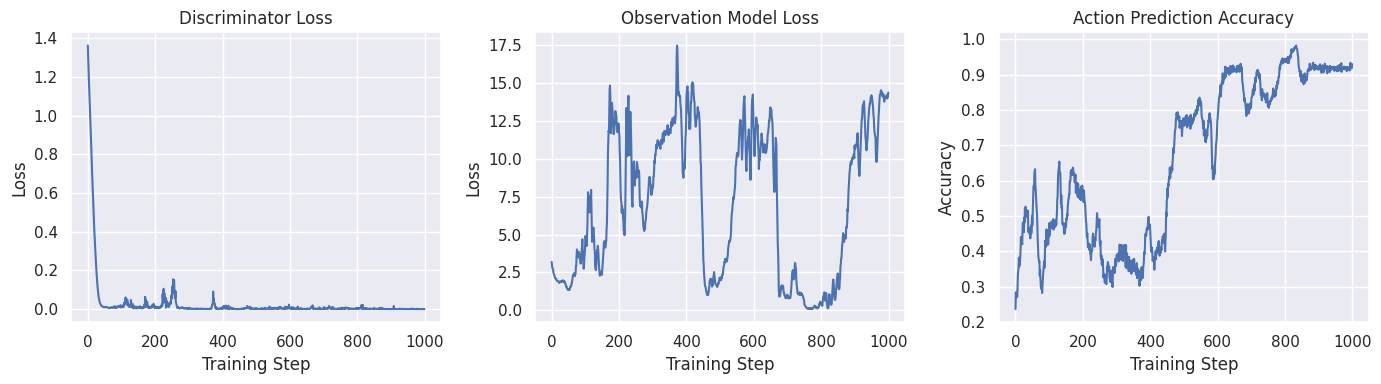

In [209]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme()

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

df = pd.DataFrame({
    'discriminator_loss': metrics['train/discriminator_loss'],
    'obs_model_loss': metrics['train/obs_model_loss'],
    'action_acc': metrics['eval/action_pred_acc'],
    'step': np.arange(metrics['train/discriminator_loss'].size)
})

sns.lineplot(df, x='step', y='discriminator_loss', ax=ax1)
ax1.set_title('Discriminator Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Training Step')

sns.lineplot(df, x='step', y='obs_model_loss', ax=ax2)
ax2.set_title('Observation Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Training Step')

sns.lineplot(df, x='step', y='action_acc', ax=ax3)
ax3.set_title('Action Prediction Accuracy')
ax3.set_ylabel('Accuracy')
ax3.set_xlabel('Training Step')

plt.tight_layout()
plt.show()

In [125]:
inputs, _ = sample_obs_modelling_batch(jax.random.PRNGKey(0))
obs_preds = obs_model.apply(train_state.obs_model_vars, inputs).round(2)

actions, msgs, noise, obs, dones = inputs
action_preds = pretrained_policy(obs_preds)[0].probs.argmax(-1)
action_preds[:5, 0], actions[:5, 0].argmax(-1)

(Array([1, 1, 4, 1, 1], dtype=int32), Array([1, 1, 4, 1, 1], dtype=int32))

In [145]:
obs.reshape((-1, 4, 2, 2, 5))[:5, 0].argmax(-1)

Array([[[0, 4],
        [1, 1]],

       [[0, 3],
        [1, 1]],

       [[0, 2],
        [1, 1]],

       [[1, 2],
        [1, 1]],

       [[4, 3],
        [4, 2]]], dtype=int32)

In [126]:
env_states = obs.reshape((-1, 4, 2, 2, 5)).argmax(-1)
env_state_preds = obs_preds.reshape((-1, 4, 2, 2, 5)).argmax(-1)

agent_pos = env_states[:, :, :, 0]
goal_pos = env_states[:, :, :, 1]

agent_pos_pred = env_state_preds[:, :, :, 0]
goal_pos_pred = env_state_preds[:, :, :, 1]

agent_pos[:5, 0], goal_pos_pred[:5, 0], dones[:5, 0]

(Array([[0, 1],
        [0, 1],
        [0, 1],
        [1, 1],
        [4, 4]], dtype=int32),
 Array([[2, 0],
        [3, 1],
        [1, 1],
        [2, 0],
        [2, 0]], dtype=int32),
 Array([False, False, False,  True,  True], dtype=bool))

In [148]:
agent_pos_pred[:4, 0]

Array([[0, 1],
       [2, 1],
       [2, 3],
       [0, 1]], dtype=int32)

In [135]:
goal_pos[:3, 0], goal_pos_pred[:3, 0]

(Array([[4, 1],
        [3, 1],
        [2, 1]], dtype=int32),
 Array([[2, 0],
        [3, 1],
        [1, 1]], dtype=int32))

In [150]:
from typing import Iterable
from poclaps.simple_gridworld_game import stringify_grid


def format_side_by_side(strings: Iterable[str]) -> str:
    """
    Format strings side by side. Assumes all strings have the same number of
    lines and each line has the same number of characters.
    """
    return '\n'.join([
        '\t'.join(lines)
        for lines in zip(*[g.split('\n') for g in strings])
    ])


def print_episode(goals, agent_pos):
    grid_strings = []

    for g, p in zip(goals, agent_pos):
        grid_str = stringify_grid(env_params.grid_size, {
            tuple(p.tolist()): 'X', tuple(g.tolist()): 'G'
        })
        grid_strings.append(grid_str)

    print(format_side_by_side(grid_strings))

In [178]:
dones[:5, 0]

Array([False, False, False,  True,  True], dtype=bool)

In [184]:
obs[:T, 0].reshape((-1, 4, 2, 2, 5)).shape

(1, 4, 2, 2, 5)

In [202]:
T = 4
ep_inputs = (actions[:T, :1], msgs[:T, :1], noise[:T, :1], obs[:T, :1], dones[:T, :1] * False)
ep_obs_preds = obs_model.apply(train_state.obs_model_vars, ep_inputs)


env_states = obs[:T, 0].reshape((-1, 4, 2, 2, 5)).argmax(-1)
env_state_preds = ep_obs_preds.reshape((-1, 4, 2, 2, 5)).argmax(-1)

agent_pos = env_states[0, :, 0]
goal_pos = env_states[0, :, 1]

agent_pos_pred = env_state_preds[0, :, 0]
goal_pos_pred = env_state_preds[0, :, 1]

In [203]:
print('True episode:')
print_episode(goal_pos, agent_pos)

True episode:
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   | G |   |   |   |	|   | G |   |   |   |	|   | G |   |   |   |	|   | G |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	| X |   |   |   |   |	|   | X |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	| X |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
| X |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
			


In [204]:
print('Predicted episode:')
print_episode(goal_pos_pred, agent_pos_pred)

Predicted episode:
---------------------	---------------------	---------------------	---------------------
|   | G |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   | G |   |   |   |	|   |   | X | G |   |	|   | G |   |   |   |
---------------------	---------------------	---------------------	---------------------
| X |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   | X |   |   |	|   |   |   |   |   |	|   |   | X |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
			
